##BASE Setup

In [0]:
!pip install fastai

In [0]:
import pandas as pd
pd.__version__

'0.24.2'

In [0]:
import fastai

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai import * 
from fastai.vision import *

##DATA

In [0]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.132 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle/14241/574364/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1567672392&Signature=MIaU5339kqiTmjQSdxQj42efcD7QNrONIRiY6BJTLTDuQpnlobhg%2BWJLiKL3iRLtuey%2BJBxjJrNJxNVdVn6P3XdKG789anTdlUyqwmcy6xOeg7eHltyI6FMWgMUOuKPM0UOpEC8M6LrDpGnGIMDbCovA8pi7Tpemb3PP4F6W4VT%2F3bldBLDYyd%2B1zmwPVfvFCTpYhz6TxP6GkgpZ6j0emiqr%2FeQ1A8k98jwSi0LPpmGjavYRIHpobZPbjp04XeWDhgmTb6fwBIqIv6O9Z6Hkr85uv0%2FEdV%2BOUEp6wc7rkrrCotg3IZQMSgXchRaGCExBRZa%2Fshpr1WWudB6zfGOceA%3D%3D&response-content-disposition=attachment%3B+filename%3Dseverstal-steel-defect-detection.zip" -O "severstal-steel-defect-detection.zip" -c

--2019-09-04 07:16:28--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/14241/574364/all.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1567672392&Signature=MIaU5339kqiTmjQSdxQj42efcD7QNrONIRiY6BJTLTDuQpnlobhg%2BWJLiKL3iRLtuey%2BJBxjJrNJxNVdVn6P3XdKG789anTdlUyqwmcy6xOeg7eHltyI6FMWgMUOuKPM0UOpEC8M6LrDpGnGIMDbCovA8pi7Tpemb3PP4F6W4VT%2F3bldBLDYyd%2B1zmwPVfvFCTpYhz6TxP6GkgpZ6j0emiqr%2FeQ1A8k98jwSi0LPpmGjavYRIHpobZPbjp04XeWDhgmTb6fwBIqIv6O9Z6Hkr85uv0%2FEdV%2BOUEp6wc7rkrrCotg3IZQMSgXchRaGCExBRZa%2Fshpr1WWudB6zfGOceA%3D%3D&response-content-disposition=attachment%3B+filename%3Dseverstal-steel-defect-detection.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1390387473 (1.3G) [application/zip]
Saving to: ‘severstal-steel-defect-detection.zip’

severs

In [0]:
import zipfile

zip_ref = zipfile.ZipFile('severstal-steel-defect-detection.zip', 'r')
zip_ref.extractall('sample_data/severstal-steel-defect-detection')
zip_ref.close()

In [0]:
!mkdir sample_data/severstal-steel-defect-detection/test_images

In [0]:
!mkdir sample_data/severstal-steel-defect-detection/train_images

In [0]:
zip_ref = zipfile.ZipFile('sample_data/severstal-steel-defect-detection/test_images.zip', 'r')
zip_ref.extractall('sample_data/severstal-steel-defect-detection/test_images')
zip_ref.close()

In [0]:
zip_ref = zipfile.ZipFile('sample_data/severstal-steel-defect-detection/train_images.zip', 'r')
zip_ref.extractall('sample_data/severstal-steel-defect-detection/train_images')
zip_ref.close()

##START

###https://www.kaggle.com/harendrap/fastai-starter-unet

In [0]:
imgsz = (256, 1600)
toy = False
bs = 4
path = Path("sample_data/severstal-steel-defect-detection")
testfolder = path/"test_images"
!mkdir -p sample_data/severstal-steel-defect-detection/checkpoints/

In [0]:
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self

In [0]:
fastai.data_block.ItemLists.transform = transform

In [0]:
# change csv so that it has image_id on one column and rles in the 4 others
def change_csv(old):
    df = pd.read_csv(old)

    def group_func(df, i):
        reg = re.compile(r'(.+)_\d$')
        return reg.search(df['ImageId_ClassId'].loc[i]).group(1)
    group = df.groupby(lambda i: group_func(df, i))
    df = group.agg({'EncodedPixels': lambda x: list(x)})
    df['ImageId'] = df.index
    df = df.reset_index(drop=True)
    df[[f'EncodedPixels_{k}' for k in range(1, 5)]] = pd.DataFrame(df['EncodedPixels'].values.tolist())
    df = df.drop(columns='EncodedPixels')
    df = df.dropna(subset=["EncodedPixels_1", "EncodedPixels_2", "EncodedPixels_3", "EncodedPixels_4"], how="all")
    df = df.fillna(value=' ') 
    return df

In [0]:
class MultiClassSegList(SegmentationLabelList):
    def open(self, id_rles):
        image_id, rles = id_rles[0], id_rles[1:]
        shape = open_image(self.path/image_id).shape[-2:]       
        final_mask = torch.zeros((1, *shape))
        for k, rle in enumerate(rles):
            if isinstance(rle, str):
                mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
                final_mask += (k + 1) * mask
        return ImageSegment(final_mask)

In [0]:
def load_data(path, df):
    train_list = (SegmentationItemList
                  .from_df(df, path=path/"train_images")
                  .split_by_rand_pct(valid_pct=0.2)
                  .label_from_df(cols=list(range(5)), label_cls=MultiClassSegList, classes=[0, 1, 2, 3, 4])
                  .add_test(testfolder.ls(), label=None)
                  .transform(get_transforms(flip_vert=True), size=imgsz, tfm_y=True)
                  .databunch(bs=bs, num_workers=0))
    return train_list

In [0]:
def dice(input:Tensor, targs:Tensor, eps:float=1e-8)->Rank0Tensor:
    input = input.clone()
    targs = targs.clone()
    n = targs.shape[0]
    input = torch.softmax(input, dim=1).argmax(dim=1)
    input = input.view(n, -1)
    targs = targs.view(n, -1)
    input[input == 0] = -999
    intersect = (input == targs).sum().float()
    union = input[input > 0].sum().float() + targs[targs > 0].sum().float()
    del input, targs
    gc.collect()
    return ((2.0 * intersect + eps) / (union + eps)).mean()

In [0]:
def visualize_one(a, b, c, title):
    fig, ax = plt.subplots(3, 1, figsize=(15, 7))
    ax[0].set_title(title)
    ax[0].imshow(a.permute(1, 2, 0))
    ax[1].imshow(b.squeeze(), vmin=0, vmax=4)
    ax[2].imshow(c.squeeze(), vmin=0, vmax=4)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    plt.show()

In [0]:
def visualize_some():
    n_batch = 0
    for batch in learn.data.train_dl:
        x, y = batch
        n_batch += 1
        if n_batch > 8:
            break
        for idx in range(bs):
            predimg, pred, _ = learn.predict(Image(x[idx].cpu()))
            visualize_one(x[idx], y[idx], pred, f"Index: {idx}")
    plt.tight_layout()

In [0]:
def print_stats(learn):
    print("Plotting Losses")
    learn.recorder.plot_losses()
    print("Plotting metrics")
    learn.recorder.plot_metrics()
    print("Plotting LR")
    learn.recorder.plot_lr()
    print("Validation losses")
    print(learn.recorder.val_losses)
    print("Metrics")
    print(learn.recorder.metrics)

In [0]:
df = change_csv(path/"train.csv")
if toy:
    df = df.sample(200)
data = load_data(path, df)
del df
import gc
gc.collect()

22

In [0]:
learn = unet_learner(data, models.resnet34, metrics=[dice], model_dir="/kaggle/working")

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


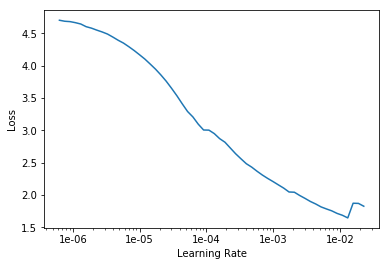

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,dice,time
0,0.166971,0.154072,0.146466,1:20:07
1,0.185693,0.131539,0.132821,1:19:10
2,0.132385,0.115881,0.189688,1:18:31
3,0.129182,0.103978,0.192668,1:17:49
4,0.135978,0.099811,0.198213,1:18:24


In [0]:
learn.save("Steel-resnet34-stage-1", return_path=True)

PosixPath('/kaggle/working/Steel-resnet34-stage-1.pth')

In [0]:
learn.load('/content/sample_data/Steel-resnet34-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5333 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: MultiClassSegList
ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600)
Path: sample_data/severstal-steel-defect-detection/train_images;

Valid: LabelList (1333 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: MultiClassSegList
ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600)
Path: sample_data/severstal-steel-defect-detection/train_images;

Test: LabelList (1801 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: EmptyLabelList
,,,,
Path: sample_data

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,dice,time
0,0.107346,0.109716,0.204080,1:31:14
1,0.106891,0.106903,0.201744,1:29:55
2,0.113236,0.105744,0.203709,1:30:36
3,0.127093,0.104241,0.201678,1:30:49
4,0.112514,0.102663,0.205854,1:30:18


In [0]:
learn.save("Steel-resnet34-stage2", return_path=True)

PosixPath('/kaggle/working/Steel-resnet34-stage2.pth')

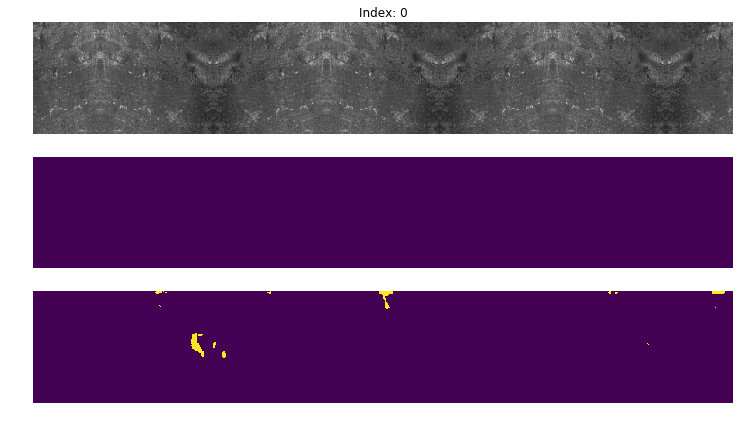

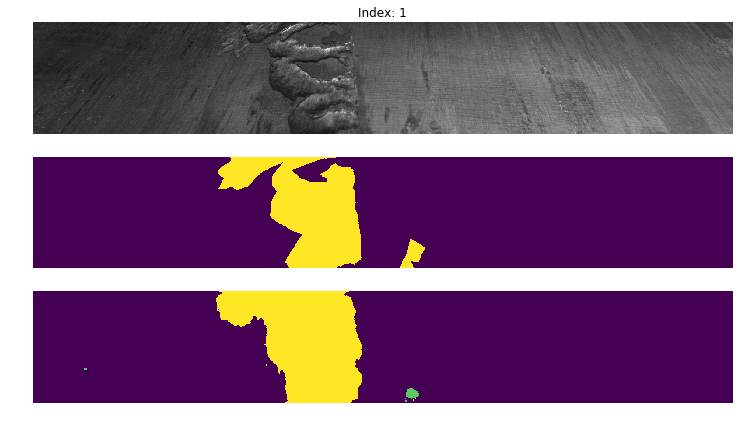

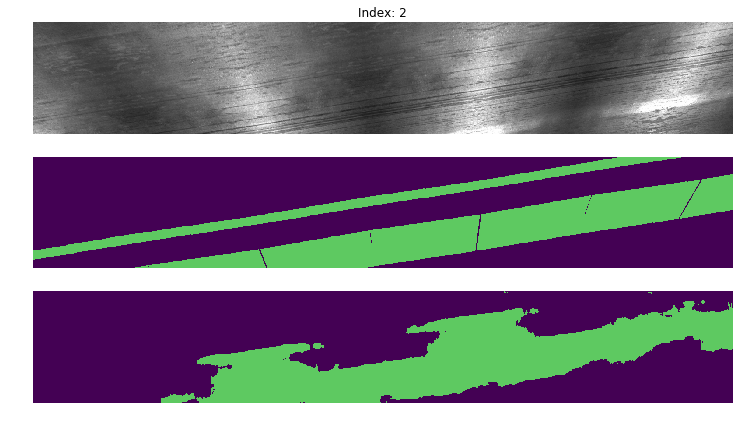

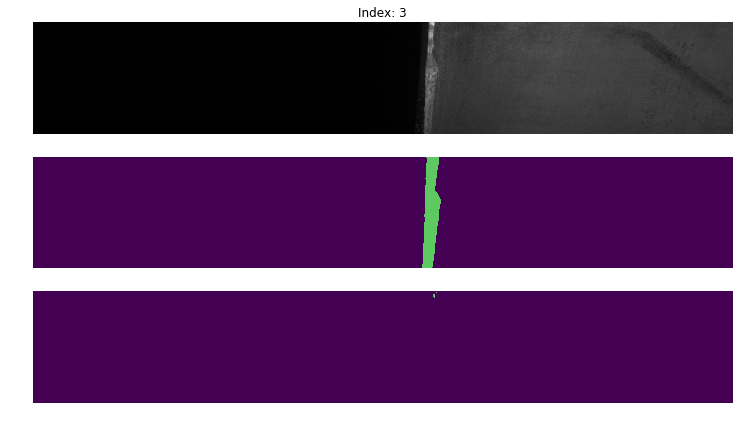

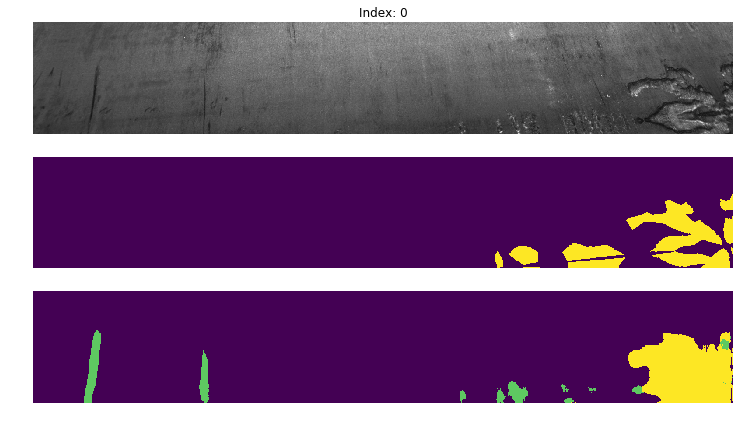

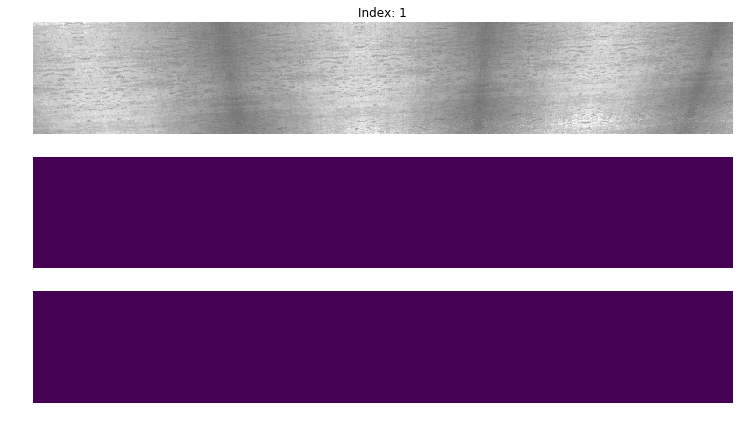

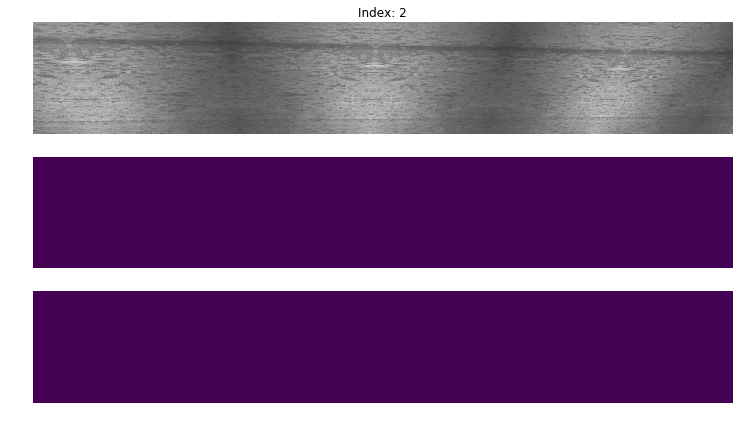

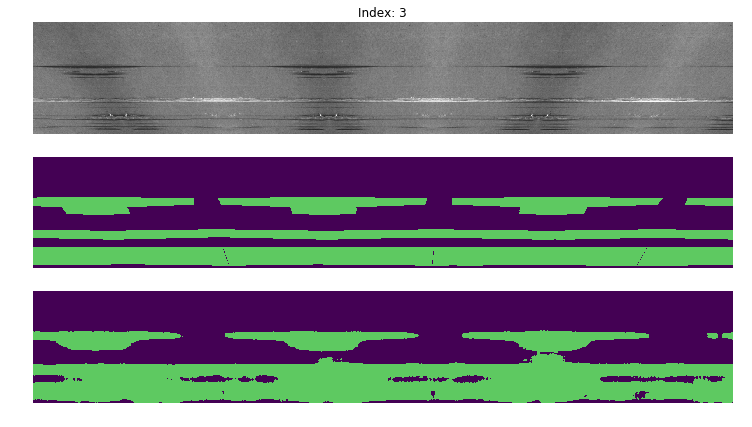

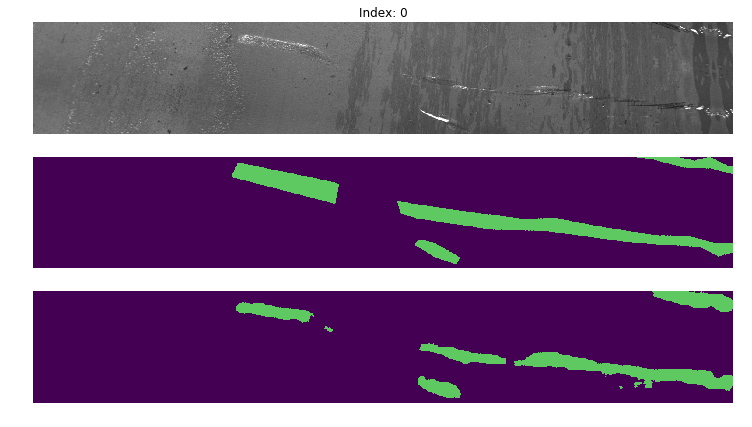

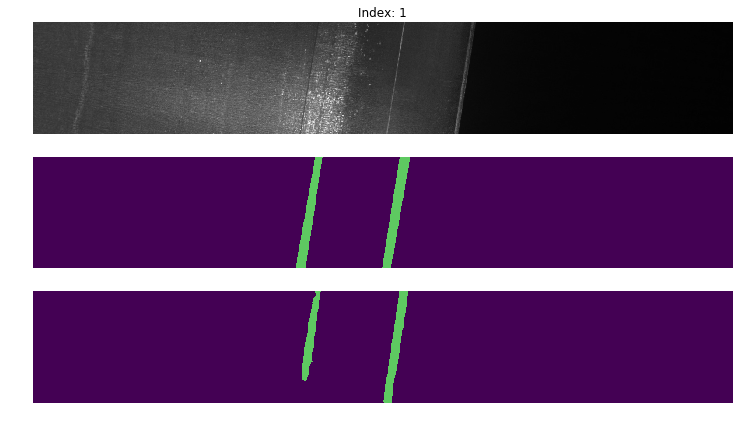

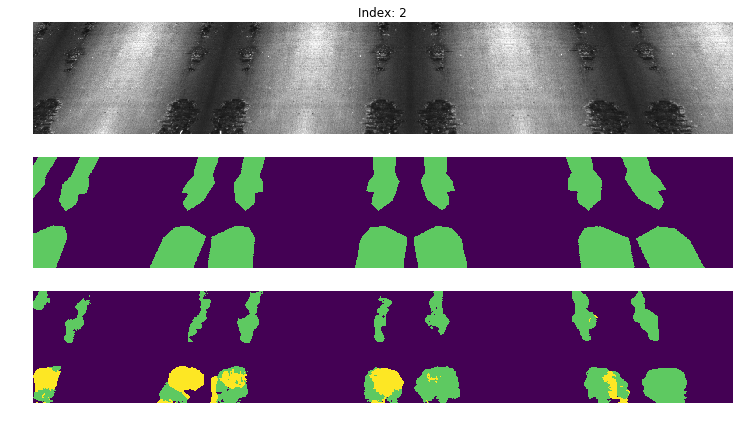

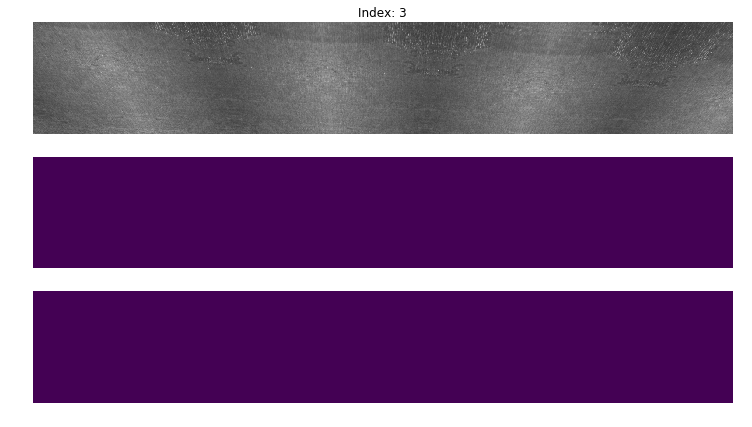

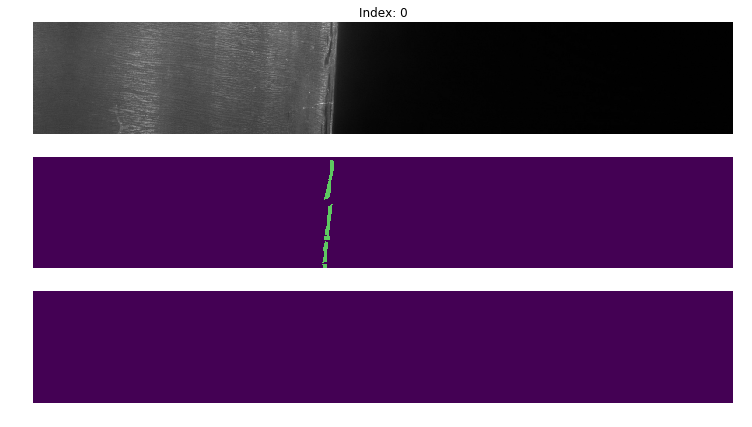

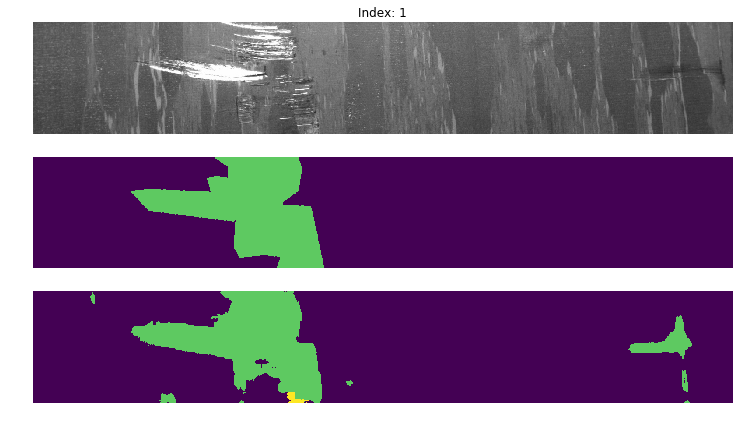

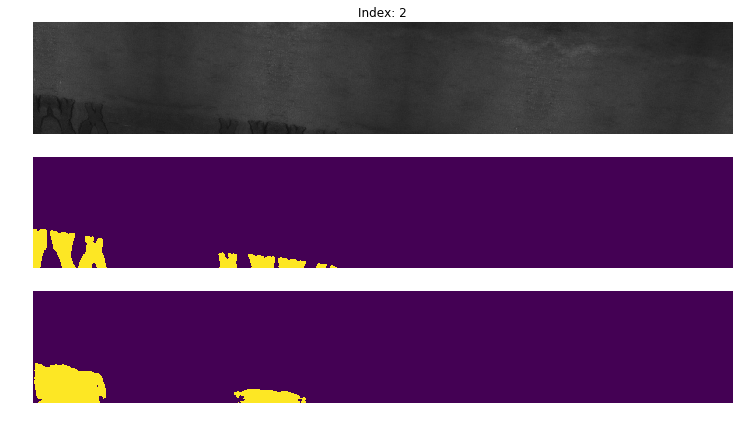

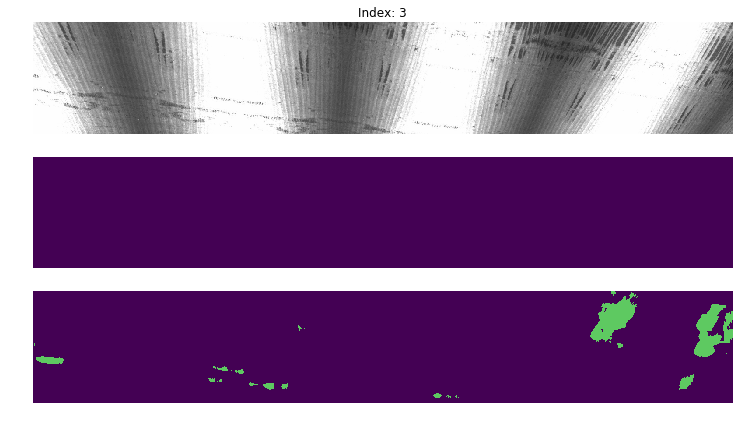

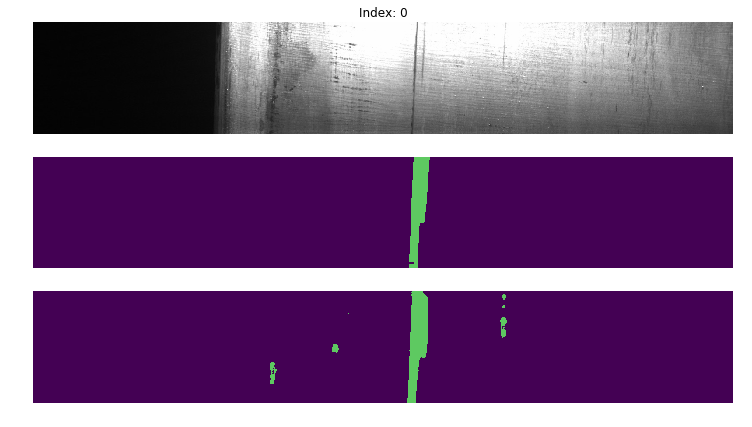

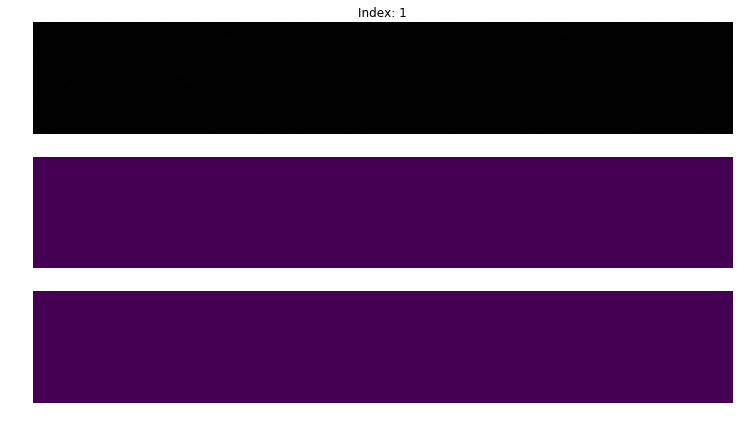

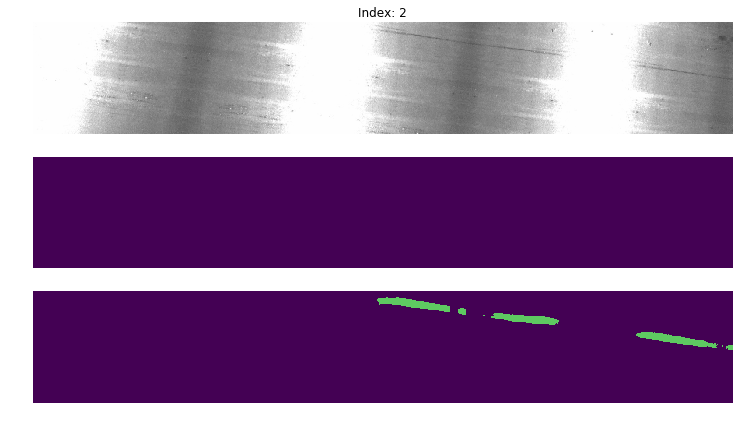

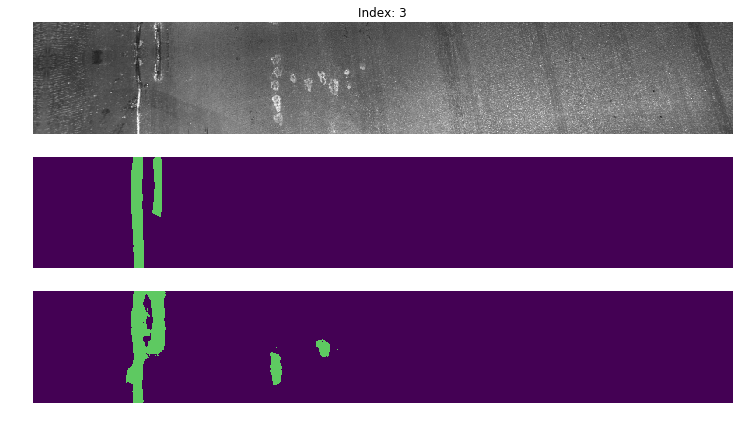

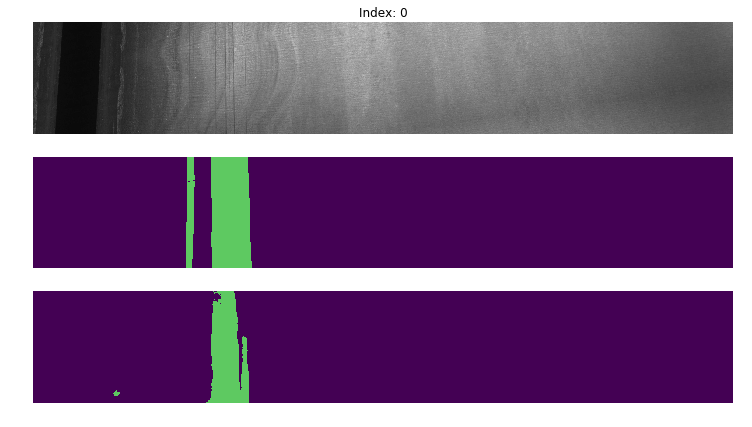

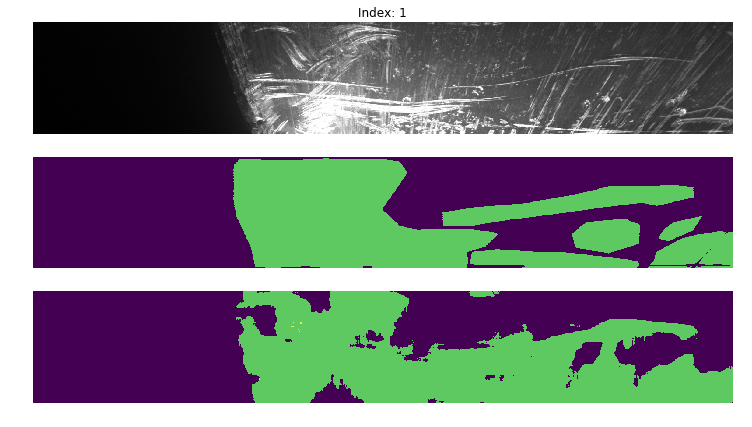

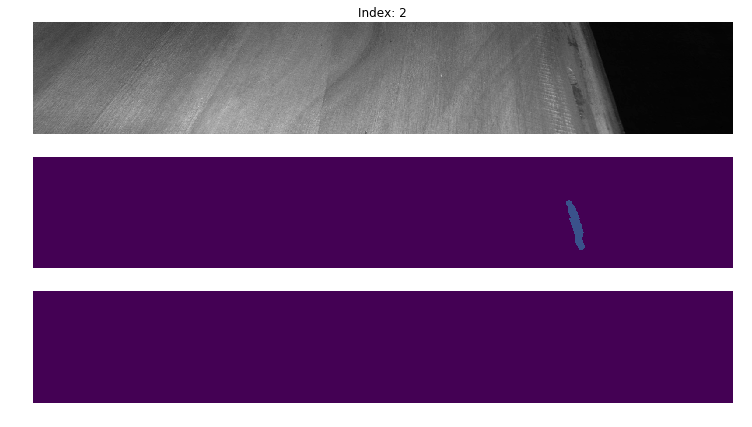

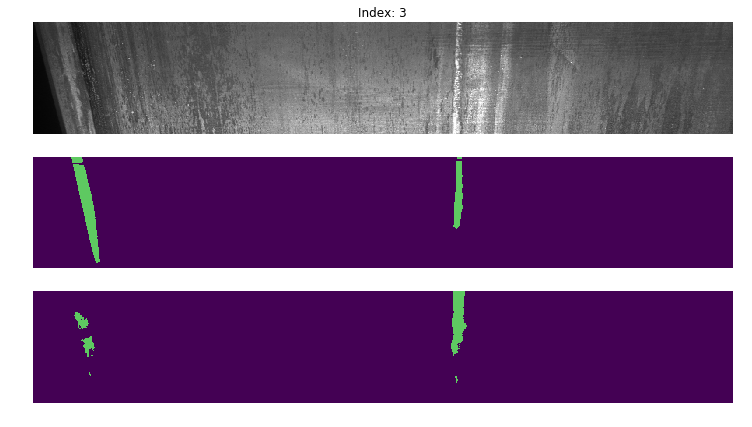

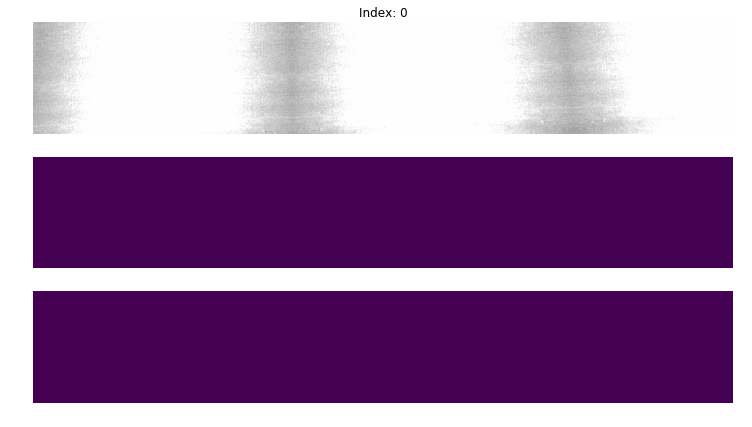

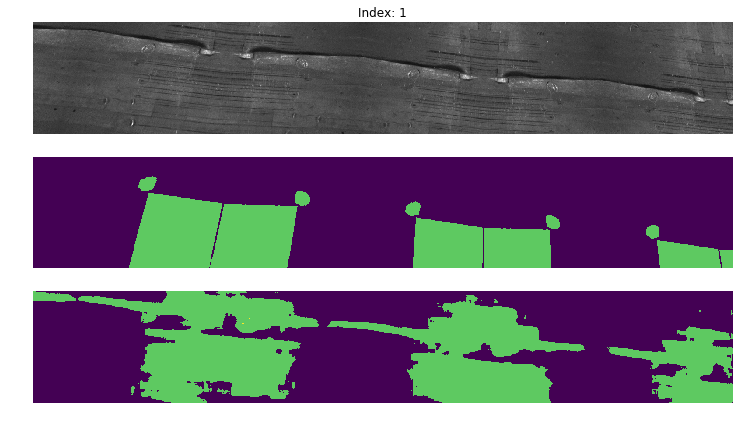

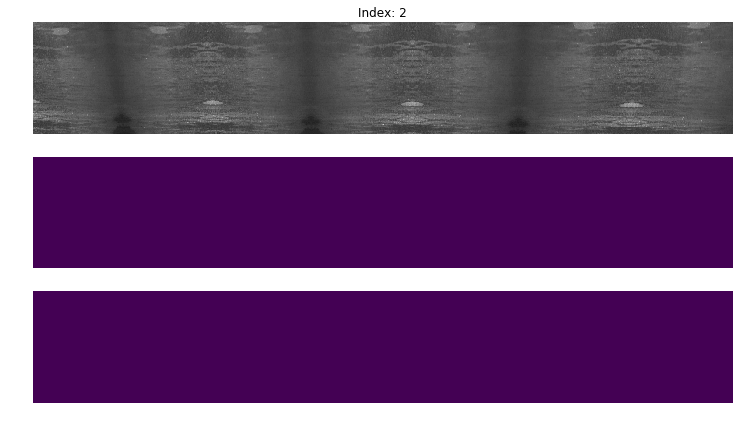

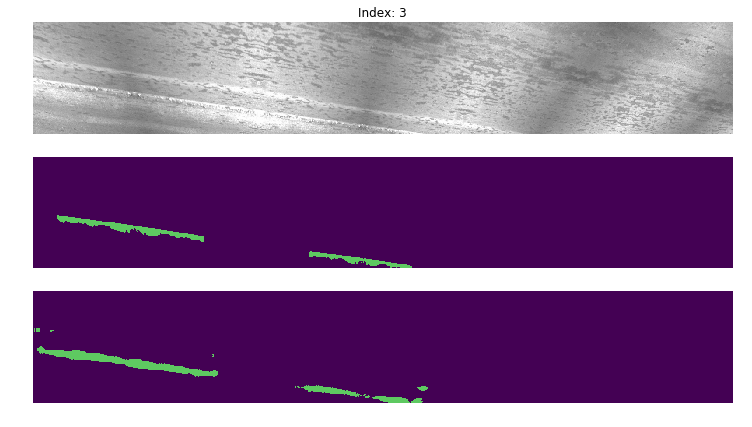

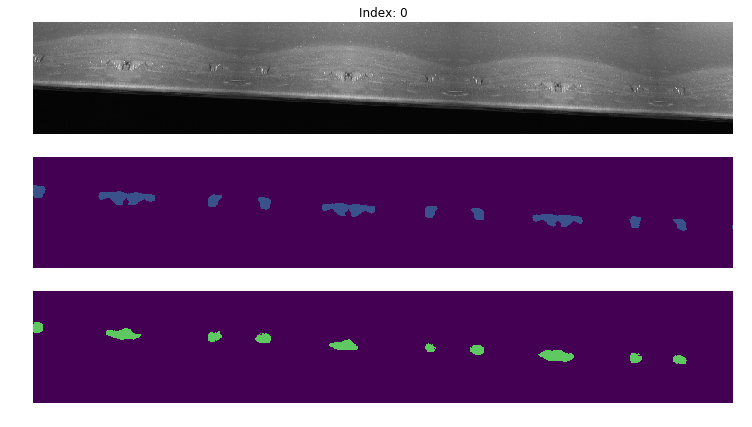

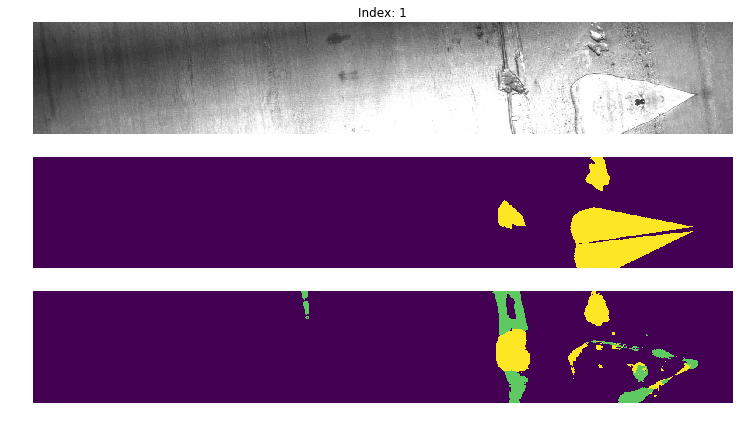

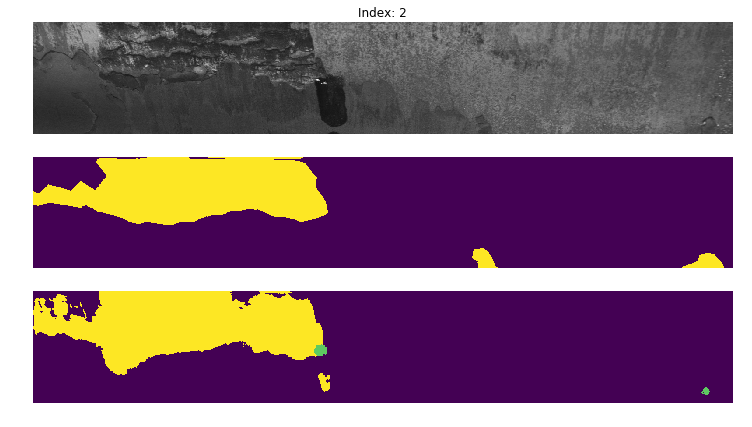

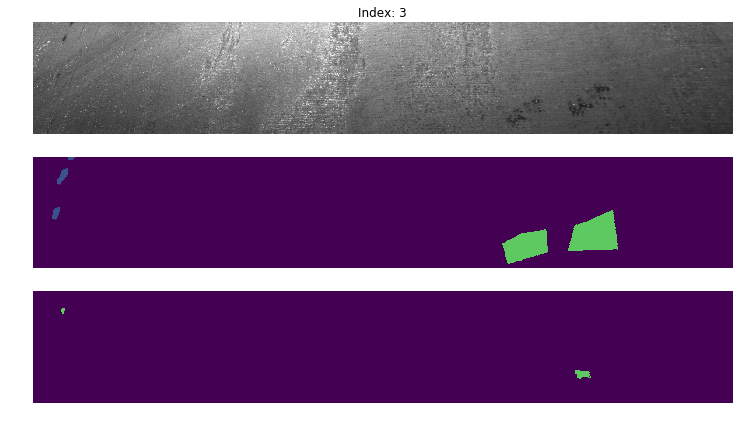

<Figure size 432x288 with 0 Axes>

In [0]:
visualize_some()

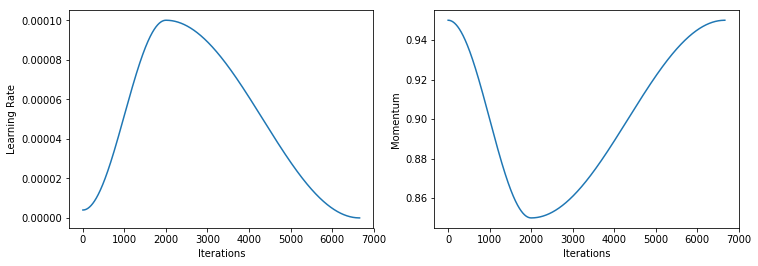

In [0]:
learn.recorder.plot_lr(show_moms=True)

In [0]:
learn.recorder.plot_metrics()

AttributeError: ignored

Plotting Losses
Plotting metrics
Plotting LR
Validation losses
[0.109715894, 0.106902525, 0.10574373, 0.104241386, 0.10266318]
Metrics
[[tensor(0.2041)], [tensor(0.2017)], [tensor(0.2037)], [tensor(0.2017)], [tensor(0.2059)]]


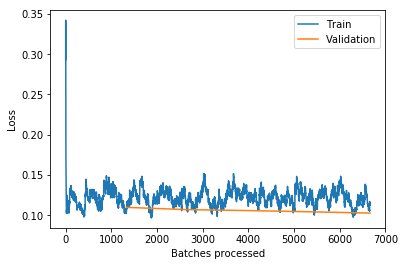

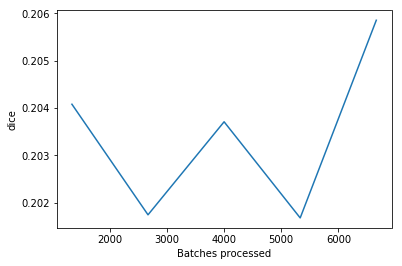

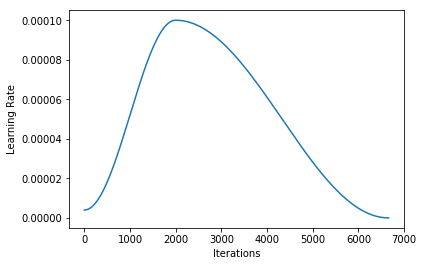

In [0]:
print_stats(learn)

In [0]:
learn.load('/content/sample_data/Steel-resnet34-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (5333 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: MultiClassSegList
ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600)
Path: sample_data/severstal-steel-defect-detection/train_images;

Valid: LabelList (1333 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: MultiClassSegList
ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600),ImageSegment (1, 256, 1600)
Path: sample_data/severstal-steel-defect-detection/train_images;

Test: LabelList (1801 items)
x: SegmentationItemList
Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600),Image (3, 256, 1600)
y: EmptyLabelList
,,,,
Path: sample_data

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9, figsize=(15,15),heatmap = True)

In [0]:
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [0]:
test_df['prediction']= preds.numpy()[:, 0]


In [0]:
test_df.head(20)


In [0]:
os.listdir('../input/test_images/')


In [0]:
test_final = test_df.loc[test_df['prediction'] <0.50]


In [0]:
test_final.describe()


In [0]:
test_df


In [0]:
test_final.to_csv('filtered_test_no_defect.csv')


In [0]:
test_final.describe()


##GOOGLE DRIVE LOAD

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /kaggle/working/Steel-resnet34-stage-1.pth 'drive/My Drive'

cp: cannot stat '/kaggle/working/Steel-resnet34-stage-1.pth': No such file or directory


In [0]:
!cp 'drive/My Drive/Steel-resnet34-stage-1.pth' /content/sample_data 

In [0]:
!cp /kaggle/working/Steel-resnet34-stage2.pth 'drive/My Drive'

cp: cannot stat '/kaggle/working/Steel-resnet34-stage2.pth': No such file or directory


In [0]:
!cp 'drive/My Drive/Steel-resnet34-stage2.pth' /content/sample_data